# Running Evals on New Models

### Evaluating the Performance of the New gpt-4o-mini-2024-07-18 and gpt-4o-2024-08-06 Models from OpenAI

As new AI models are released, it's essential for companies using large language models (LLMs) in their applications to quickly assess their performance for specific use cases. In this notebook, I will generate predictions using two recently released models from OpenAI and compare them with predictions from previously tested models. I will analyze the differences in outputs through a series of use case-specific evaluations. The objective is to make informed decisions about the benefits and trade-offs of adopting the new models.

Prior to running this analysis, I was using gpt-4o-mini in production and getting acceptable results. This systematic process will help determine whether it would be advantageous to change the model to gpt-4o-mini-2024-07-18 or gpt-4o-2024-08-06.

### Specific Use Case: Medical Charting Application
[**soapnotescribe**](https://github.com/josephrmartinez/soapnotescribe) is a web application that utilizes AI to automatically generate structured clinical notes from medical appointment recordings.

The application workflow involves first sending the audio of the medical appointment to a speech-to-text model hosted by Replicate. The transcribed text is then processed by a large language model (served by OpenAI or Anthropic) to organize the content into a structured data object, which is subsequently presented to the physician as a SOAP note.



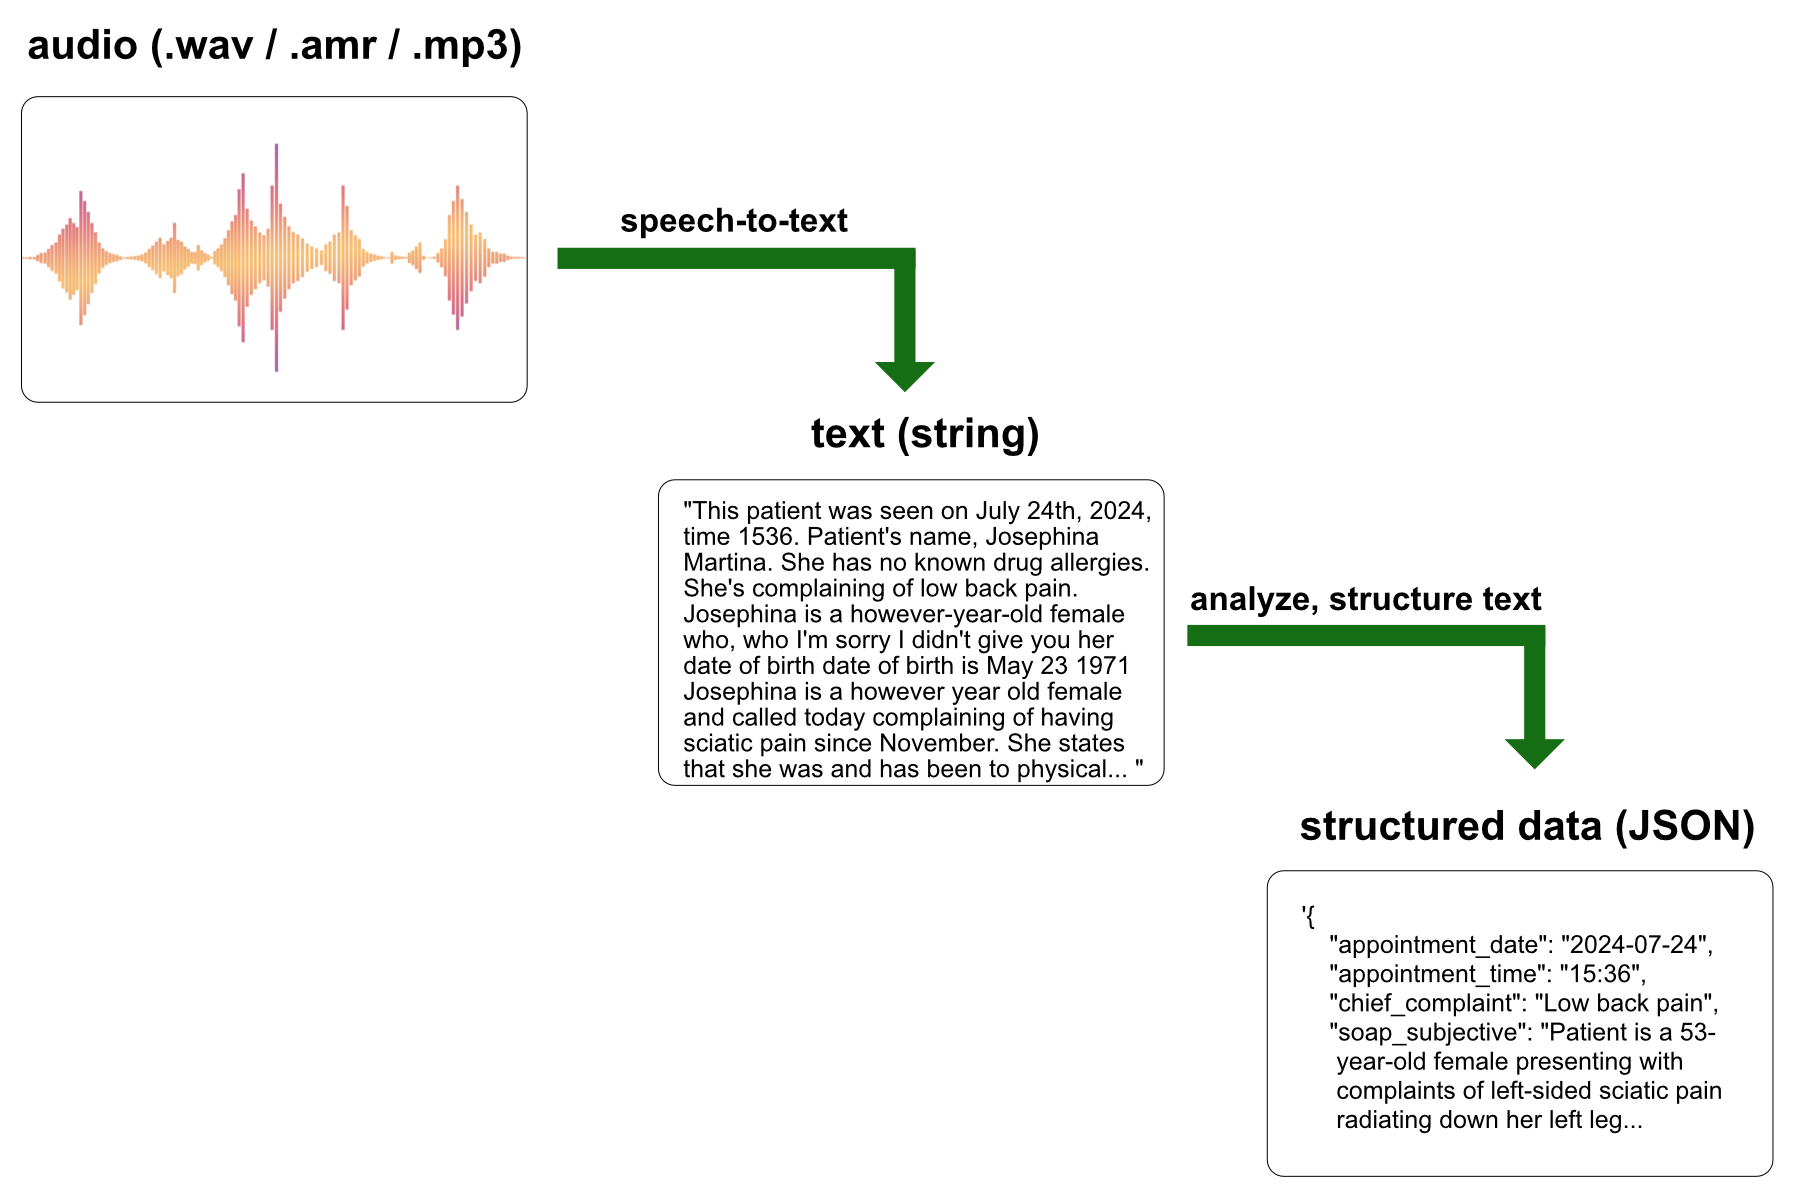



While all major foundational models can generate acceptable SOAP notes from audio transcriptions, they differ significantly in completion times, costs, and quality. Simple pass/fail evaluations are not sufficient to grasp the performance differences of different models under consideration.

The objective of this notebook is to systematically evaluate the performance of models available to convert audio transcriptions into structured SOAP notes and determine whether the application should be updated with one of the newly released models from OpenAI.

Goals:
- **Evaluate Performance for Specific Use Case**: Analyze and measure the performance of different models on key variables.
- **Model Selection**: Choose the optimal model based on a comprehensive evaluation of performance, cost, and suitability for this specific use case.
- **Preparedness for New Models**: Develop a framework for immediate analysis and evaluation when new models are released, enabling a clear understanding of the costs and benefits of switching models.

## **GENERATE PREDICTIONS**

In [109]:
!pip install openai
!pip install anthropic
!pip install matplotlib

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import json
from openai import OpenAI
import anthropic

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')

In [113]:
openai = OpenAI(api_key=OPENAI_API_KEY)
anthropic = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

In [114]:
medications = [
    "Aspirin",
    "Acetaminophen",
    "Ibuprofen",
    "Naproxen",
    "Flexeril",
    "Hydrocodone",
    "Oxycodone",
    "Tramadol",
    "Lidocaine",
    "Epinephrine",
    "Nitroglycerin",
    "Albuterol",
    "Prednisone",
    "Dexamethasone",
    "Amoxicillin",
    "Azithromycin",
    "Cephalexin",
    "Ciprofloxacin",
    "Metronidazole",
    "Clindamycin",
    "Lorazepam",
    "Diazepam",
    "Midazolam",
    "Fentanyl",
    "Morphine",
    "Ondansetron",
    "Promethazine",
    "Diphenhydramine",
    "Hydrocortisone",
    "Ipratropium",
    "Atropine",
    "Naloxone",
    "Flumazenil",
    "Metoprolol",
    "Lisinopril",
    "Losartan",
    "Hydrochlorothiazide",
    "Simvastatin",
    "Warfarin",
    "Heparin",
    "Insulin",
    "Glucagon",
    "Nitrofurantoin",
    "Sulfamethoxazole/Trimethoprim",
    "Chlorhexidine",
    "Ranitidine",
    "Omeprazole",
    "Pantoprazole"
]

In [115]:
system_content_strings = {
    1: """
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
""",
    2: """
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
- Be vigilant for formatting and spelling errors in the transcript, particularly regarding prescription medications. Correct these errors accurately. Pay special attention to the spelling and formatting of any prescription medications mentioned.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
""",
    3: f"""
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
- Be vigilant for formatting and spelling errors in the transcript, particularly regarding prescription medications. Here is a list of common medication names: {medications} . The transcript may include misspellings of these or other medications. Be sure to provide the correct spelling. Correct medication dosage transcriptions by standardizing the format to use a slash ("/") between different ingredient amounts. Convert verbal expressions of dosage, such as "five slash three twenty-five milligrams" or "five milligrams and three hundred twenty-five milligrams," to the format "5/325 milligrams." Ensure the correct separation of amounts and units according to standard prescription practices.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
"""
    }

In [116]:
transcript = """
This patient was seen on July 24th, 2024, time 1536. Patient's name, Josephina Martina. She has no known drug allergies. She's complaining of low back pain. Josephina is a however-year-old female who, who I'm sorry I didn't give you her date of birth date of birth is May 23 1971 Josephina is a however year old female and called today complaining of having sciatic pain since November. She states that she was and has been to physical therapy she was doing better however it has worsened recently causing her to have left left-sided sciatic pain radiating down her left leg she reports of pain as being constant she denies any red flags such as saddle anesthesia, loss of urine or bowel control, and she denies having any weakness to the extremity. prescribed physical therapy, but no other workup for her. She has not had an MRI of her lumbar spine. She is on tenazidine for migraine headaches, but is not on any medication for this. She calls today with an acute flare-up and is requesting to be treated for it until she can get in to see her primary care doctor she denies any abdominal pain dysuria or hematuria she sees she's otherwise healthy she has no known drug allergies and no significant medical problems except for the migraine headaches. Based on her symptomatology and the fact that she is young and otherwise healthy, I will treat her for acute sciatica with lumbar go, but I have recommended that she undergo an MRI of her lumbar spine if she has not had any imaging as she may have a ruptured disc, nerve impingement, or degenerative disc disease. Her diagnosis is acute lumbar go with left-sided sciatica the plan is I have prescribed a medull dose pack to be dispensed per pharmacist no refill flexor all 20 milligram tablets used to take one POB ID PRN muscle spasm and Vicodin 5-3, 25 milligrams. She used to take one to two POQ, four to six hours, PRN pain, dispense 20, no refill."""

In [117]:
user_content_string = f"""
Give me a thorough SOAP note from the following transcript. Return your response as a JSON object. /// TRANSCRIPT: {transcript} """

In [118]:
openai_models = ['gpt-3.5-turbo', 'gpt-4-turbo', 'gpt-4o', 'gpt-4o-mini']

In [119]:
new_openai_models = ['gpt-4o-mini-2024-07-18', 'gpt-4o-2024-08-06']

In [120]:
openai_temperatures = [1]

In [121]:
anthropic_models = ['claude-3-haiku-20240307', 'claude-3-5-sonnet-20240620', 'claude-3-opus-20240229']

In [122]:
anthropic_temperatures = [1]

In [123]:
iterations = 10

In [124]:
model_pricing = {
    "gpt-4-turbo": {
        "input_token_cost": 0.01,
        "output_token_cost": 0.03
    },
    "gpt-4o": {
        "input_token_cost": 0.005,
        "output_token_cost": 0.015
    },
    "gpt-4o-2024-08-06": {
        "input_token_cost": 0.00250,
        "output_token_cost": 0.01
    },
    "gpt-4o-mini": {
        "input_token_cost": 0.00015,
        "output_token_cost": 0.0006
    },
    "gpt-4o-mini-2024-07-18": {
        "input_token_cost": 0.00015,
        "output_token_cost": 0.0006
    },
    "gpt-3.5-turbo": {
        "input_token_cost": 0.0005,
        "output_token_cost": 0.0015
    },
    "claude-3-haiku-20240307": {
        "input_token_cost": 0.00025,
        "output_token_cost": 0.00125
    },
    "claude-3-5-sonnet-20240620": {
        "input_token_cost": 0.003,
        "output_token_cost": 0.015
    },
    "claude-3-opus-20240229": {
        "input_token_cost": 0.015,
        "output_token_cost": 0.075
    }
}

**Ensuring Consistent JSON Outputs from LLMs with Tool Calling**

When using LLMs to convert unstructured data into structured data, defining a JSON schema is essential. While OpenAI and Anthropic provide a "JSON mode," it only ensures the output is valid JSON, not that it adheres to a specific schema.

To enforce a specific JSON schema, you must define it in the tool_choice parameter (as OpenAI has deprecated function calling). Avoid placing the schema in the system prompt.

The examples below demonstrate how to properly define a JSON schema and use it within the tool calling feature for both OpenAI and Anthropic.

**Note on Structured Outputs Feature**

On August 6, 2024, OpenAI introduced the Structured Outputs feature: [Structured Outputs Announcement](https://openai.com/index/introducing-structured-outputs-in-the-api/).

This feature improves upon JSON mode by ensuring responses adhere to developer-supplied JSON schemas. However, the Structuerd Outputs feature does not currently support certain keywords like pattern, format, and maxLength. For applications using JSON schemas with these keywords, it is necessary to continue using tool calling for now.

In [125]:
JSON_schema_tool_calling = {
          "type": "object",
          "properties": {
            "appointment_date": {
              "type": "string",
              "format": "date",
              "pattern": "^\\d{4}-\\d{2}-\\d{2}$",
              "description": "Date of the appointment in yyyy-mm-dd format"
            },
            "appointment_time": {
              "type": "string",
              "pattern": "^\\d{2}:\\d{2}$",
              "description": "Time of the appointment in hh:mm format"
            },
            "chief_complaint": {
              "type": "string",
              "maxLength": 50,
              "description": "Chief complaint. Capitalize the first letter of the string"
            },
            "soap_subjective": {
              "type": "string",
              "description": "Subjective information from the patient. DO NOT include patient name or date of birth."
            },
            "soap_objective": {
              "type": "string",
              "description": "Objective observations and measurements. Narrative format or UNORDERED list. DO NOT include patient name or date of birth."
            },
            "soap_assessment": {
              "type": "string",
              "description": "Assessment and diagnosis. Narrative format or UNORDERED list. NO DIFFERENTIAL DIAGNOSIS in this field."
            },
            "soap_plan": {
              "type": "string",
              "description": "Plan for treatment and patient education. Be sure to correct spelling and formatting of medications. Narrative format or UNORDERED list."
            },
            "differential_diagnosis": {
              "type": "string",
              "description": "Differential diagnosis. Always include alternative treatment options. Narrative format or UNORDERED list."
            },
            "patient_location": {
              "type": "string",
              "description": "Location of the patient (State/Province, e.g., 'Arizona'). Only include this key if the patient location is clearly mentioned in the transcript."
            }
          }
        }

In [126]:
#OpenAI API prediction request:

def get_analysis_openai(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0, prompt_version: int = 1):
    print(f"calling get_analysis_openai with model: {model}")
    start_time = time.time()

    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content_string},
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            response_format={"type": "json_object"},
            tools=[{
                "type": "function",
                "function": {
                    "name": "JSON_soap_note",
                    "description":"Clinical SOAP note as a JSON object",
                    "parameters": JSON_schema_tool_calling
                }
            }],
            tool_choice={"type": "function", "function": {"name": "JSON_soap_note"}},
        )

        completion_string = response.choices[0].message.tool_calls[0].function.arguments
        usage = response.usage

        input_tokens = usage.prompt_tokens
        output_tokens = usage.completion_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': completion_string,
            'prompt_version': prompt_version
        }

        # Parse completion string
        try:
            completion_data = json.loads(completion_string)
            response_data.update(completion_data)
        except json.JSONDecodeError:
            pass

        return response_data



    except Exception as e:
        print("Error getting OpenAI completion data:", e)
        return {'error': str(e)}

In [127]:
# Test OpenAI API prediction once:

model='gpt-4o-mini-2024-07-18'
temperature = 1
prompt_version = 3
system_content_string = system_content_strings[prompt_version]

result = get_analysis_openai(system_content_string, user_content_string, model, temperature, prompt_version)
print(result)


calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
{'model': 'gpt-4o-mini-2024-07-18', 'temperature': 1, 'input_tokens': 1348, 'output_tokens': 400, 'input_cost': 0.00015, 'output_cost': 0.0006, 'prediction_cost': 0.0004422, 'prediction_time': 9.291984558105469, 'completion_string': '{"appointment_date":"2024-07-24","appointment_time":"15:36","chief_complaint":"Low back pain","soap_subjective":"Josephina Martina is a female patient, born on May 23, 1971, who presents with complaints of sciatic pain that started in November. She reports that her pain has worsened recently, describing it as left-sided sciatica radiating down her left leg. The pain is constant. She denies any red flags such as saddle anesthesia, loss of bowel or bladder control, or weakness in the extremities. She is otherwise healthy, has no known drug allergies, and no significant medical problems other than migraine headaches for which she is taking tenazidine. She has previously attended physical therapy a

In [ ]:
# Get predictions for each OpenAI model:

results_openai = []

prompt_version = 3
system_content_string = system_content_strings[prompt_version]

for model in openai_models:
    for temperature in openai_temperatures:
        for _ in range(iterations):
            result = get_analysis_openai(system_content_string, user_content_string, model, temperature, prompt_version)
            if result:
                results_openai.append(result)

# Convert results to a DataFrame
df_results_openai = pd.DataFrame(results_openai)

# Save to csv
if os.path.exists('results-openai.csv'):
    df_results_openai.to_csv('results-openai.csv', mode='a', header=False, index=False)
else:
    df_results_openai.to_csv('results-openai.csv', index=False)



In [130]:
# Get predictions for just the newly released OpenAI models:

results_openai = []

prompt_version = 3
system_content_string = system_content_strings[prompt_version]

for model in new_openai_models:
    for temperature in openai_temperatures:
        for _ in range(iterations):
            result = get_analysis_openai(system_content_string, user_content_string, model, temperature, prompt_version)
            if result:
                results_openai.append(result)

# Convert results to a DataFrame
df_results_openai = pd.DataFrame(results_openai)

# Save to csv
if os.path.exists('results-openai.csv'):
    df_results_openai.to_csv('results-openai.csv', mode='a', header=False, index=False)
else:
    df_results_openai.to_csv('results-openai.csv', index=False)


calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
calling get_analysis_openai with model: gpt-4o-2024-08-06
calling get_analysis_openai with model: gpt-4o-2024-08-06
calling get_analysis_openai with model: gpt-4o-2024-08-06
calling get_analysis_openai with model: gpt-4o-2024-08-06
calling get_analysis_openai with model: gpt-4o-2024-08-06
calling get_analysis_openai with model: gpt-4o-2024-08-06
calling get_analysis_o

In [128]:
#Anthropic API prediction request:

def get_analysis_anthropic(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0, prompt_version: int = 1):
    print(f"calling get_analysis_anthropic with model: {model}")
    start_time = time.time()

    try:
        response = anthropic.messages.create(
            model=model,
            messages=[
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            system=system_content_string,
            max_tokens=4096,
            tool_choice={"type": "tool", "name":"JSON_soap_note"},
            tools=[{
                "name": "JSON_soap_note",
                "description":"Clinical SOAP note as a JSON object",
                "input_schema": JSON_schema_tool_calling
                }]
        )

        tool_use_block = response.content[0]

        soap_note = tool_use_block.input

        usage = response.usage
        input_tokens = usage.input_tokens
        output_tokens = usage.output_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': json.dumps(soap_note),
            'prompt_version': prompt_version
        }

        response_data.update(soap_note)


        return response_data

    except Exception as e:
        print("Error getting Anthropic completion data:", e)
        return {'error': str(e)}

In [129]:
# Test Anthropic API prediction once:

model = 'claude-3-haiku-20240307'
temperature = 1
prompt_version = 3
system_content_string = system_content_strings[prompt_version]

result = get_analysis_anthropic(system_content_string, user_content_string, model, temperature, prompt_version)

print(result)

calling get_analysis_anthropic with model: claude-3-haiku-20240307
{'model': 'claude-3-haiku-20240307', 'temperature': 1, 'input_tokens': 2028, 'output_tokens': 646, 'input_cost': 0.00025, 'output_cost': 0.00125, 'prediction_cost': 0.0013145000000000001, 'prediction_time': 4.48801589012146, 'completion_string': '{"appointment_date": "2024-07-24", "appointment_time": "15:36", "chief_complaint": "Low back pain", "differential_diagnosis": "- Lumbar radiculopathy due to disc herniation\\n- Lumbar degenerative disc disease\\n- Piriformis syndrome\\nAlternative treatment options include physical therapy, epidural steroid injections, non-steroidal anti-inflammatory medications, and potentially surgical intervention for severe or persistent symptoms.", "patient_location": "Unknown", "soap_assessment": "Acute lumbar radiculopathy with left-sided sciatica. Based on the patient\'s symptomatology and lack of concerning \\"red flag\\" symptoms, the most likely diagnosis is acute exacerbation of lum

In [ ]:
# Get predictions for each Anthropic model:

results_anthropic = []

prompt_version = 3
system_content_string = system_content_strings[prompt_version]

for model in anthropic_models:
    for temperature in anthropic_temperatures:
        for _ in range(iterations):
            result = get_analysis_anthropic(system_content_string, user_content_string, model, temperature, prompt_version)
            if result:
                results_anthropic.append(result)

# Convert results to a DataFrame
df_results_anthropic = pd.DataFrame(results_anthropic)

# Save to csv
if os.path.exists('results-anthropic.csv'):
    df_results_anthropic.to_csv('results-anthropic.csv', mode='a', header=False, index=False)
else:
    df_results_anthropic.to_csv('results-anthropic.csv', index=False)

calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-2024

## **EVALUATE PREDICTIONS**

**Reminder:**
- gpt-4o-mini is the model currently used in production

**Models previously evaluated:**
- gpt-3.5-turbo
- gpt-4o
- gpt-4o-mini
- claude-3-haiku-20240307
- claude-3-5-sonnet-20240620

**New models evaluated:**
- gpt-4o-mini-2024-07-18
- gpt-4o-2024-08-06

In [158]:
# Load csv file with combined results of new predictions with previous predictions

df = pd.read_csv('/content/drive/MyDrive/soapnotescribe/model_evals_2024_08_07.csv')


### **Analysis: Prediction Time**

In [159]:
# Exclude certain models from analysis
# df = df.loc[df['model'] != 'claude-3-5-sonnet-20240620']

avg_time = df.groupby('model')['prediction_time'].mean().reset_index(name='avg_time')

grouped_time = df.groupby('model')['prediction_time'].agg(['min', 'max']).reset_index()
grouped_time = pd.merge(grouped_time, avg_time, left_on='model', right_on='model')

grouped_time = grouped_time.sort_values(by='avg_time', ascending=True)

print(grouped_time)

                        model        min        max   avg_time
1     claude-3-haiku-20240307   3.373190   4.549827   3.840245
2               gpt-3.5-turbo   2.851042   7.056668   4.254387
4           gpt-4o-2024-08-06   4.480846   7.399112   5.617025
3                      gpt-4o   5.321071   7.979249   6.383797
5                 gpt-4o-mini   5.862834   9.466123   7.607287
6      gpt-4o-mini-2024-07-18   7.713273  12.710019   9.715752
0  claude-3-5-sonnet-20240620  14.588888  23.093392  18.804123


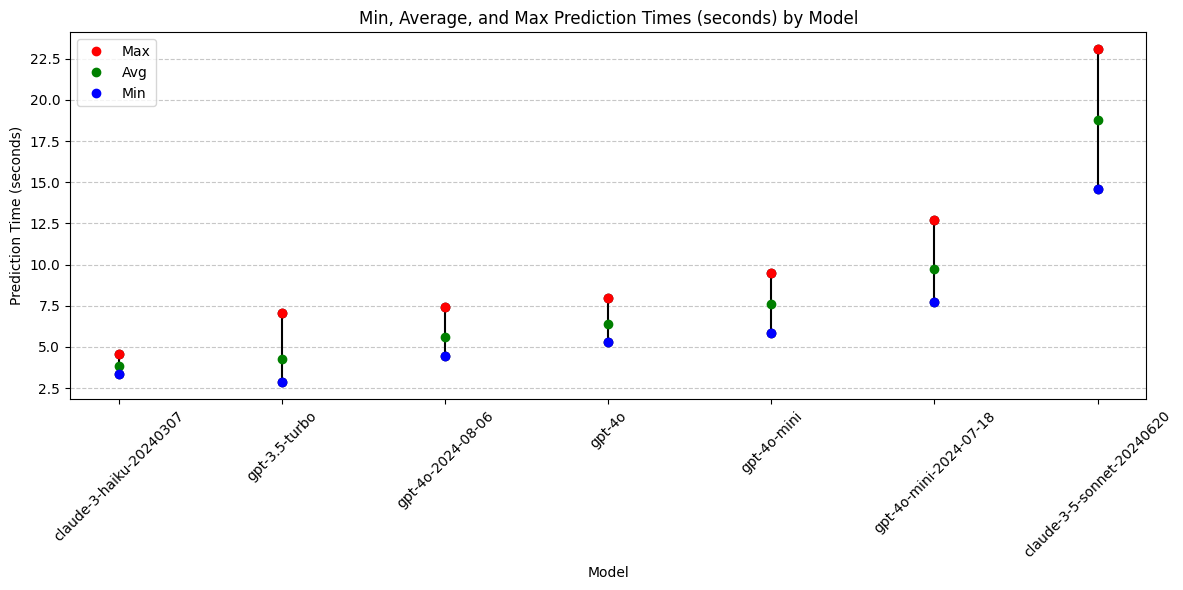

In [160]:
plt.figure(figsize=(12, 6))

for i, row in grouped_time.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg_time'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Time (seconds)')
plt.title('Min, Average, and Max Prediction Times (seconds) by Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [176]:
# Function to calculate absolute and relative differences of avg prediction times between two models

def calculate_avg_time_difference(df: pd.DataFrame, model1: str, model2: str) -> float:
    df1 = df.loc[df['model'] == model1]
    df2 = df.loc[df['model'] == model2]
    avg_time1 = df1['prediction_time'].mean()
    avg_time2 = df2['prediction_time'].mean()

    absolute_difference = avg_time1 - avg_time2
    relative_difference = (absolute_difference / avg_time2) * 100 if avg_time1 != 0 else float('inf')  # Avoid division by zero

    # Format the results
    result = (f"{model1} avg prediction time: {avg_time1:.2f} seconds\n"
              f"{model2} avg prediction time: {avg_time2:.2f} seconds\n"
              f"Absolute difference: {absolute_difference:.2f} seconds\n"
              f"Relative difference: {relative_difference:.2f}%")

    return result

In [177]:
# Calculate prediction time difference between 'gpt-4o-mini-2024-07-18' and 'gpt-4o-mini':
difference = calculate_avg_time_difference(df, 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini' )
print(difference)

gpt-4o-mini-2024-07-18 avg prediction time: 9.72 seconds
gpt-4o-mini avg prediction time: 7.61 seconds
Absolute difference: 2.11 seconds
Relative difference: 27.72%


In [178]:
# Calculate prediction time difference between 'gpt-4o-2024-08-06' and 'gpt-4o':
difference = calculate_avg_time_difference(df, 'gpt-4o-2024-08-06', 'gpt-4o' )
print(difference)

gpt-4o-2024-08-06 avg prediction time: 5.62 seconds
gpt-4o avg prediction time: 6.38 seconds
Absolute difference: -0.77 seconds
Relative difference: -12.01%


#### **Conclusions: Prediction Time**

- Switching from gpt-4o-mini to gpt-4o-mini-2024-07-18 appears to increase prediction time and variability.
  - Average gpt-4o-mini-2024-07-18 predictions take about 2.1 seconds (28%) longer than average gpt-4o-mini predictions
- gpt-4o-2024-08-06 appears similar to but slightly faster than gpt-4o
  - Average gpt-4o-2024-08-06 predictions take about 0.77 seconds (12%) less time than average gpt-4o predictions.
- Prediction time is not the most important criteria for this use-case, but getting predictions in under ten seconds is desirable. For this reason, switching from gpt-4o-mini to gpt-4o-mini-2024-07-18 does not look advatageous.  

**Top Models for Prediction Speed and Consistency:**
- claude-3-haiku (reliably under 5 seconds)
- gpt-3.5-turbo
- gpt-4o-2024-08-06

## **Analysis: Prediction Cost**

In [135]:
# Calculate average cost, grouping by model
avg_cost = df.groupby(['model'])['prediction_cost'].mean().reset_index(name='avg')

# Calculate min and max costs, grouping by model
grouped_cost = df.groupby(['model'])['prediction_cost'].agg(['min', 'max']).reset_index()

# Merge the grouped cost with the average cost
grouped_cost = pd.merge(grouped_cost, avg_cost, on=['model'])

# Sort the DataFrame by avg cost in ascending order
grouped_cost = grouped_cost.sort_values(by='avg', ascending=True)

print(grouped_cost)


                        model       min       max       avg
6      gpt-4o-mini-2024-07-18  0.000392  0.000440  0.000416
5                 gpt-4o-mini  0.000476  0.000571  0.000522
2               gpt-3.5-turbo  0.001076  0.001236  0.001175
1     claude-3-haiku-20240307  0.001123  0.001322  0.001215
4           gpt-4o-2024-08-06  0.006270  0.007590  0.006884
3                      gpt-4o  0.012710  0.015095  0.013369
0  claude-3-5-sonnet-20240620  0.020064  0.023559  0.022044


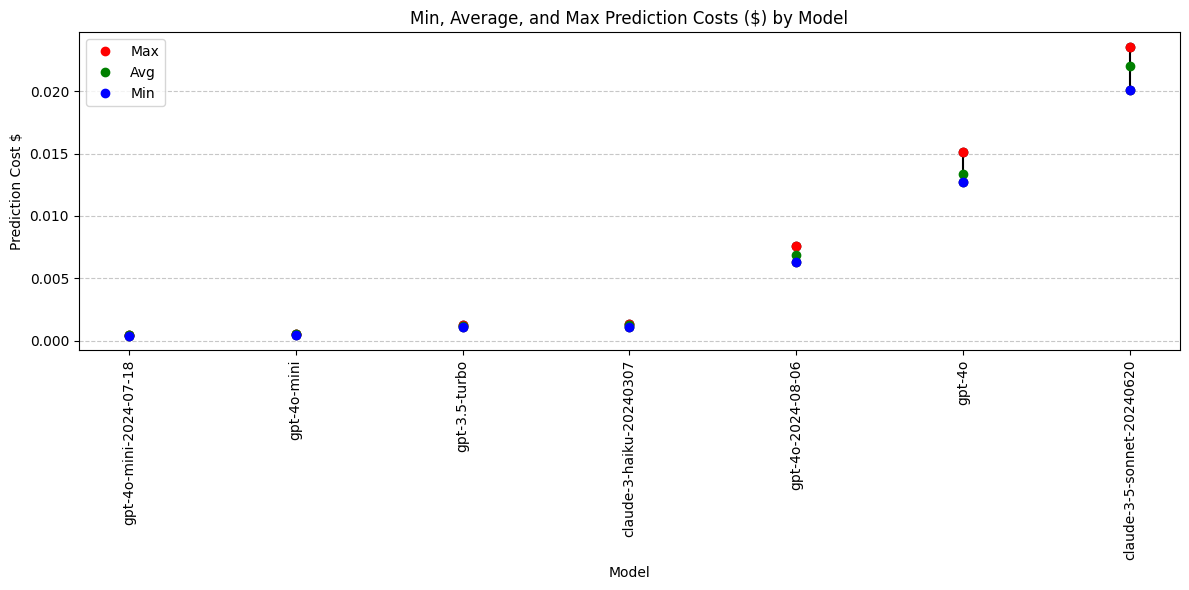

In [136]:
plt.figure(figsize=(12, 6))

for i, row in grouped_cost.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Cost $')
plt.title('Min, Average, and Max Prediction Costs ($) by Model')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [195]:
# Function to calculate absolute and relative differences of avg cost between two models

def calculate_avg_cost_difference(df: pd.DataFrame, model1: str, model2: str) -> float:
    df1 = df.loc[df['model'] == model1]
    df2 = df.loc[df['model'] == model2]
    avg_output1 = df1['prediction_cost'].mean()
    avg_output2 = df2['prediction_cost'].mean()

    absolute_difference = avg_output1 - avg_output2
    relative_difference = (absolute_difference / avg_output2) * 100

    # Format the results
    result = (f"{model1} avg prediction cost: ${avg_output1:.5f}\n"
              f"{model2} avg prediction cost: ${avg_output2:.5f}\n"
              f"Absolute difference: {absolute_difference:.5f}\n"
              f"Relative difference: {relative_difference:.2f}%")

    return result

In [196]:
# Calculate prediction cost difference between 'gpt-4o-2024-08-06' and 'gpt-4o':
difference = calculate_avg_cost_difference(df, 'gpt-4o-2024-08-06', 'gpt-4o' )
print(difference)

gpt-4o-2024-08-06 avg prediction cost: $0.00688
gpt-4o avg prediction cost: $0.01337
Absolute difference: -0.00648
Relative difference: -48.51%


In [197]:
# Calculate prediction cost difference between 'gpt-4o-mini-2024-07-18' and 'gpt-4o-mini':
difference = calculate_avg_cost_difference(df, 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini' )
print(difference)

gpt-4o-mini-2024-07-18 avg prediction cost: $0.00042
gpt-4o-mini avg prediction cost: $0.00052
Absolute difference: -0.00011
Relative difference: -20.37%


### **Conclusions: Prediction Cost**

- gpt-4o-2024-08-06 is 48.5% less expensive than gpt-4o.
- gpt-4o-mini-2024-07-18 is 20.4% less expensive than gpt-4o-mini.
- gpt-4o-mini-2024-07-18 is now the least expensive model.


Models with lowest cost:
- gpt-4o-mini-2024-07-18
- gpt-4o-mini
- gpt-3.5-turbo
- claude-3-haiku

## **Analysis: Output Tokens**

Are the new models returning less output tokens?


In [148]:
# Exclude claude-3-opus model
#df = df.loc[df['model'] != 'claude-3-opus-20240229']

avg_output_tokens = df.groupby(['model'])['output_tokens'].mean().reset_index(name='avg_output')

grouped_output = df.groupby(['model'])['output_tokens'].agg(['min', 'max']).reset_index()
grouped_output = pd.merge(grouped_output, avg_output_tokens, on=['model'])

grouped_output = grouped_output.sort_values(by=['model'])

grouped_output = grouped_output.sort_values(by='avg_output')

print(grouped_output)

                        model  min   max  avg_output
2               gpt-3.5-turbo  252   359       318.2
4           gpt-4o-2024-08-06  290   422       351.4
6      gpt-4o-mini-2024-07-18  316   396       356.3
3                      gpt-4o  393   552       436.9
5                 gpt-4o-mini  453   611       529.9
1     claude-3-haiku-20240307  490   649       563.9
0  claude-3-5-sonnet-20240620  945  1178      1077.0


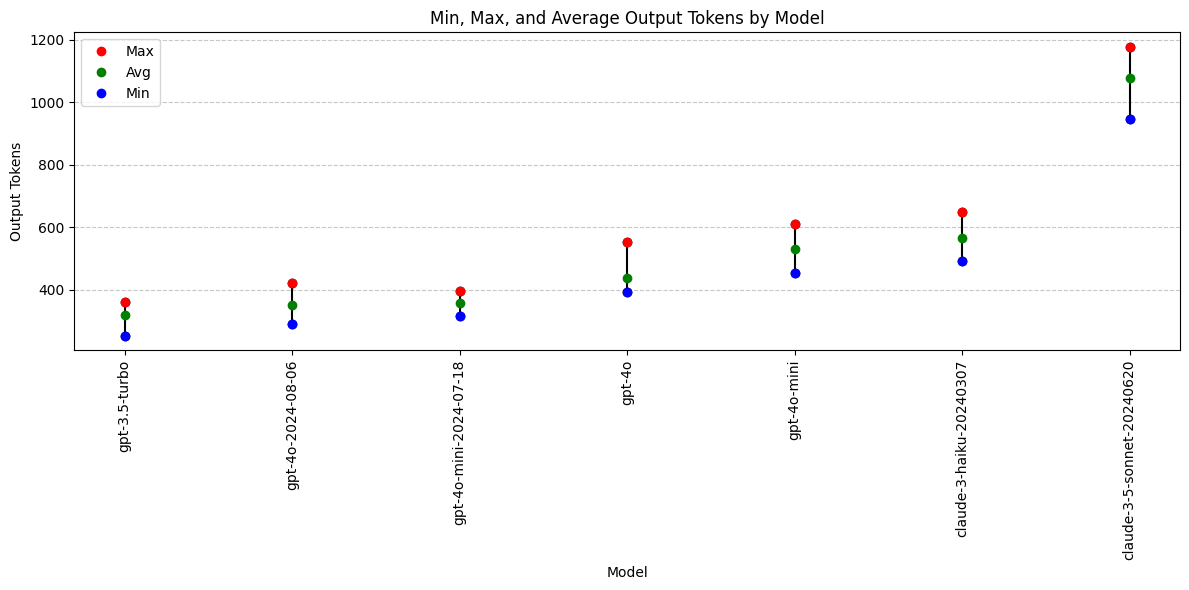

In [147]:
plt.figure(figsize=(12, 6))

for i, row in grouped_output.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg_output'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Output Tokens')
plt.title('Min, Max, and Average Output Tokens by Model')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [198]:
# Function to calculate absolute and relative differences of avg output tokens between two models

def calculate_avg_output_difference(df: pd.DataFrame, model1: str, model2: str) -> float:
    df1 = df.loc[df['model'] == model1]
    df2 = df.loc[df['model'] == model2]
    avg_output1 = df1['output_tokens'].mean()
    avg_output2 = df2['output_tokens'].mean()

    absolute_difference = avg_output1 - avg_output2
    relative_difference = (absolute_difference / avg_output2) * 100

    # Format the results
    result = (f"{model1} avg output tokens: {avg_output1:.2f} tokens\n"
              f"{model2} avg output tokens: {avg_output2:.2f} tokens\n"
              f"Absolute difference: {absolute_difference:.2f} tokens\n"
              f"Relative difference: {relative_difference:.2f}%")

    return result

In [199]:
# Calculate output token difference between 'gpt-4o-2024-08-06' and 'gpt-4o':
difference = calculate_avg_output_difference(df, 'gpt-4o-2024-08-06', 'gpt-4o' )
print(difference)

gpt-4o-2024-08-06 avg output tokens: 351.40 tokens
gpt-4o avg output tokens: 436.90 tokens
Absolute difference: -85.50 tokens
Relative difference: -19.57%


In [200]:
# Calculate output token difference between 'gpt-4o-mini-2024-07-18' and 'gpt-4o-mini':
difference = calculate_avg_output_difference(df, 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini' )
print(difference)

gpt-4o-mini-2024-07-18 avg output tokens: 356.30 tokens
gpt-4o-mini avg output tokens: 529.90 tokens
Absolute difference: -173.60 tokens
Relative difference: -32.76%


**Output Token Conclusions**
- The new models from OpenAI appear to be less verbose than their counterpart models.
  - gpt-4o-2024-08-06 returns about 20% less tokens than gpt-4o
  - gpt-4o-mini-2024-07-18 returns about 33% less tokens than gpt-4o-mini
- This less verbose behavior may not be advantageous. Brevity is not nessesarily preferred for this use case.
- Anthropic's Claude models generally produce more verbose outputs compared to OpenAI's GPT models.
  - claude-3-5-sonnet is an outlier in output token length.


Models with output token preference:
- Not applicable. Longer/shorter is not necessarily better.

## **Analysis: Differential Diagnosis**
- Was a Differential Diagnosis returned? If so, what was the average length?
- How many Differential Diagnosis values included "alternative treatments" as requested in the system prompt?

In [201]:
# Function to calculate the length of differential diagnosis or zero if empty
def diagnosis_length(diagnosis: str):
    return len(diagnosis) if diagnosis else 0

In [202]:
df['differential_diagnosis'] = df['differential_diagnosis'].fillna('')

# Add a new column for the length of differential diagnosis
df['diff_diag_length'] = df['differential_diagnosis'].apply(diagnosis_length)

# Count the number of rows with a non-empty differential diagnosis
df['has_diff_diag'] = df['differential_diagnosis'].apply(lambda x: 1 if x else 0)

# Check if 'alternative' is in the differential diagnosis
df['has_alternative'] = df['differential_diagnosis'].apply(lambda x: 1 if 'alternative' in x.lower() else 0)

# Calculate the average length of differential diagnosis
avg_diff_length = df.groupby(['model'])['diff_diag_length'].mean().reset_index(name='avg_diff_length')

# Count the number of rows with a non-empty differential diagnosis
total_diff_diag = df.groupby(['model'])['has_diff_diag'].sum().reset_index(name='total_diff_diag')

# Count the number of rows with 'alternative' in the differential diagnosis
total_alternative = df.groupby(['model'])['has_alternative'].sum().reset_index(name='total_alternative')

# Merge the results
grouped_output = pd.merge(avg_diff_length, total_diff_diag, on=['model'])
grouped_output = pd.merge(grouped_output, total_alternative, on=['model'])

# Sort the DataFrame by avg_diff_length in ascending order
grouped_output = grouped_output.sort_values(by='avg_diff_length', ascending=True)

print(grouped_output)

                        model  avg_diff_length  total_diff_diag  \
6      gpt-4o-mini-2024-07-18            151.1               10   
3                      gpt-4o            225.6               10   
4           gpt-4o-2024-08-06            228.0               10   
2               gpt-3.5-turbo            267.3               10   
1     claude-3-haiku-20240307            306.4               10   
5                 gpt-4o-mini            370.3               10   
0  claude-3-5-sonnet-20240620           1342.3               10   

   total_alternative  
6                  5  
3                  5  
4                 10  
2                 10  
1                  5  
5                  8  
0                 10  


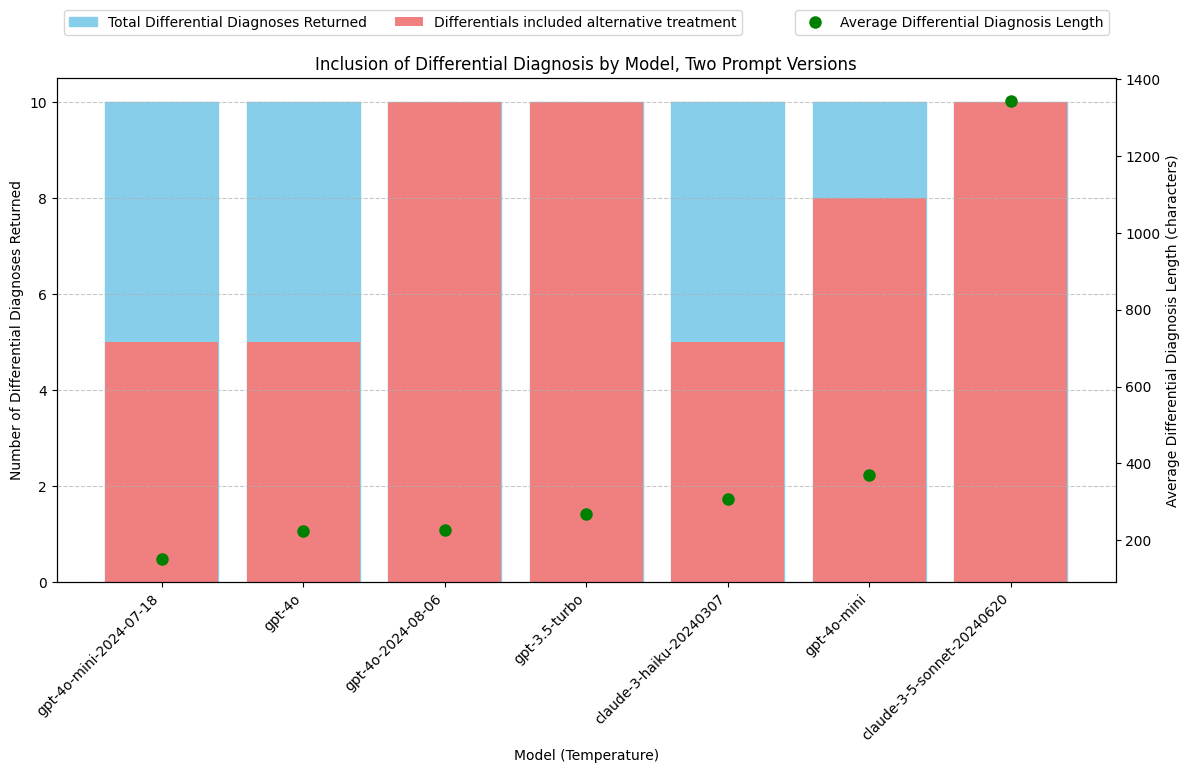

In [203]:

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for total differentials
bar1 = ax1.bar(grouped_output['model'], grouped_output['total_diff_diag'], label='Total Differential Diagnoses Returned', color='skyblue', edgecolor='skyblue')

# Bar chart for differentials that include "alternative"
bar2 = ax1.bar(grouped_output['model'], grouped_output['total_alternative'], label='Differentials included alternative treatment', color='lightcoral')

# Secondary y-axis for average differential diagnosis length
ax2 = ax1.twinx()
ax2.plot(grouped_output['model'], grouped_output['avg_diff_length'], color='green', marker='o', linestyle='', linewidth=2, markersize=8, label='Average Differential Diagnosis Length')

# Customizing the plot
ax1.set_xlabel('Model (Temperature)')
ax1.set_ylabel('Number of Differential Diagnoses Returned')
ax2.set_ylabel('Average Differential Diagnosis Length (characters)')
ax1.set_title('Inclusion of Differential Diagnosis by Model, Two Prompt Versions')
ax1.set_xticks(range(len(grouped_output['model'])))
ax1.set_xticklabels(grouped_output['model'], rotation=45, ha='right')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol=2)
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.15), ncol=1)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions: Differential Diagnosis**

The claude-3-5-sonnet model is an outliere with Differential Diagnosis outputs that are 3 to 5 times longer than those from other models.

Manual review indicates that these longer outputs are of high quality and significantly enrich the SOAP notes.

**gpt-4o-2024-08-06**
- gpt-4o-2024-08-06 returns a differrential about the same length as gpt-4o
- gpt-4o-2024-08-06 is better at including alternative treatments than gpt-4o

**gpt-4o-mini-2024-07-18**
- gpt-4o-mini-2024-07-18 returns a differrential about half the length as gpt-4o-mini
- This less verbose behavior may not be advantageous. Brevity is not nessesarily preferred for this use case.
- gpt-4o-mini-2024-07-18 is worse at including alternative treatments than gpt-4o-mini




**Best Models for Differential Diagnosis:**

- Claude-3.5-Sonnet: Consistently provides a detailed Differential Diagnosis along with alternative treatment options, as requested. Notably produces longer, more comprehensive responses.
- gpt-3.5-turbo: Reliably returns a Differential Diagnosis with alternative treatment options.
- gpt-4o-2024-08-06: Reliably returns a Differential Diagnosis with alternative treatment options.


## **Analysis: Fixing Transcription Errors**

The transcript includes the text "Vicodin 5-3, 25 milligrams" for when the speaker said "Vicodin five slash three twenty-five milligrams." This should have been transcribed as "Vicodin 5/325 milligrams."

The dosage of medications is typically written with a slash ("/") to clearly separate the amounts of each ingredient. "5" represents the amount of hydrocodone (usually in milligrams), and "325" represents the amount of acetaminophen (also in milligrams).
"Vicodin 5/325" means each tablet contains 5 mg of hydrocodone and 325 mg of acetaminophen.

The transcript also includes a spelling error related to a medication name: "flexor all 20 milligram tablets" should be "Flexeril 20 milligram tablets".

While this was not specifically requested in the prompt, some of the models caught these mistakes in the transcript and automatically fixed them in the response.

In [142]:
# Function to calculate whether the soap_plan includes the text 5/325
def check_formatting(soap_plan: str):
    return 1 if "5/325" in soap_plan else 0

In [143]:
# Function to calculate whether the soap_plan includes the text flexeril
def check_spelling(soap_plan: str):
    return 1 if "flexeril" in soap_plan.lower() else 0

In [144]:
# Exclude claude-3-opus model
# df = df.loc[df['model'] != 'claude-3-opus-20240229']

# Add a new column to store whether soap_plan includes corrrect formatting of 5/325
df['corrected_formatting'] = df['soap_plan'].apply(check_formatting)

# Add a new column to store whether soap_plan includes corrected spelling of flexeril
df['corrected_spelling'] = df['soap_plan'].apply(check_spelling)

# Count the number of rows with correct formatting
total_formatted = df.groupby(['model'])['corrected_formatting'].sum().reset_index(name='total_formatted')

# Count the number of rows with correct spelling
total_spelling = df.groupby(['model'])['corrected_spelling'].sum().reset_index(name='total_spelling')

# Merge the results ()
grouped_output = pd.merge(total_formatted, total_spelling, on=['model'], how='inner')

# Sort the DataFrame by total_formatted in ascending order
grouped_output = grouped_output.sort_values(by='total_formatted', ascending=True)

print(grouped_output)

                        model  total_formatted  total_spelling
0  claude-3-5-sonnet-20240620               10               9
1     claude-3-haiku-20240307               10              10
2               gpt-3.5-turbo               10               5
3                      gpt-4o               10              10
4           gpt-4o-2024-08-06               10              10
5                 gpt-4o-mini               10              10
6      gpt-4o-mini-2024-07-18               10              10


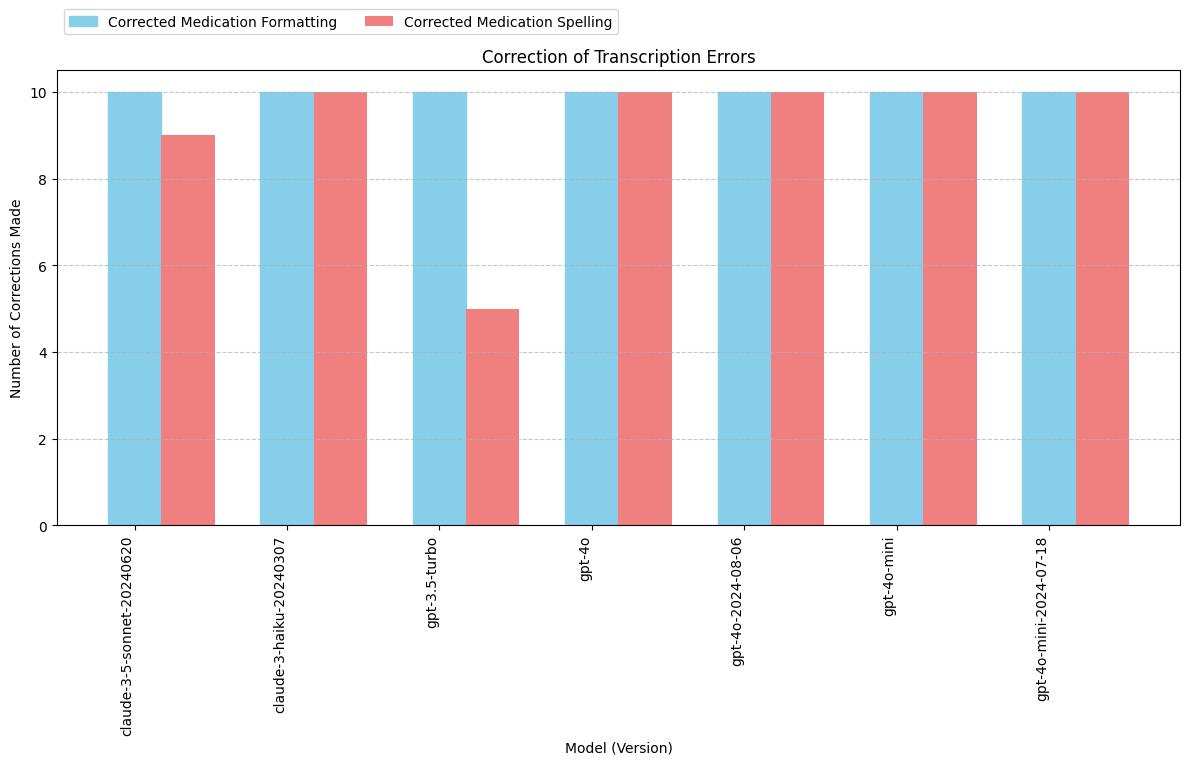

In [145]:

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.35
opacity = 0.8

# Bar chart for total corrected values
bar1 = ax1.bar(grouped_output['model'], grouped_output['total_formatted'], width=bar_width, label='Corrected Medication Formatting', color='skyblue', edgecolor='skyblue')
bar2 = ax1.bar([x + bar_width for x in range(len(grouped_output['model']))], grouped_output['total_spelling'], width=bar_width, label='Corrected Medication Spelling', color='lightcoral')

# Customizing the plot
ax1.set_xlabel('Model (Version)')
ax1.set_ylabel('Number of Corrections Made')
ax1.set_title('Correction of Transcription Errors')
ax1.set_xticks(range(len(grouped_output['model'])))
ax1.set_xticklabels(grouped_output['model'], rotation=90, ha='right')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol=2)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions: Fixing Transcription Errore**

**General improvement with prompt update**:
- All of the models, except for Claude-3-Haiku, showed performance improvement in detecting transcription errors with the updated prompt.

**Best model for fixing transcription errors**:
- GPT-4o excelled at identifying spelling and formatting errors in prescription medications, outperforming all other models even with the initial prompt (Prompt V1).

**General Observations**:
- The updated system prompt and JSON schema have enhanced the detection of medication transcription errors, but issues persist, particularly with formatting. Spelling errors are generally easier to identify than formatting issues. It may be beneficial to provide the prompt with examples of correct medication formatting to further reduce errors.



## **CONCLUSIONS**

### **Model Rankings by Criteria**

To determine the "best model," it's crucial to identify and evaluate the most important criteria for your use case. Model performance can vary significantly across these criteria. The following rankings are organized from the most to least important criteria for this particular application:


### **Change in Performance by Criteria**
**gpt-4o-mini-2024-07-18 compared to gpt-4o-mini**

**Cost:**
- Worse

**Inclusion of Differential Diagnosis and alternative treatment:**
- Worse (shorter, less reliable at including alternative treatment options)

**Fixing transcription errors:**
- Worse

**Prediction times:**
- Worse (2.11 seconds / 27.7% longer avg time)



### **Change in Performance by Criteria**
**gpt-4o-2024-08-06 rcompared to gpt-4o**

**Cost:**
- Better (48% cost)

**Inclusion of Differential Diagnosis and alternative treatment:**
- Better (same length, more reliably includes alternative treatment options)

**Fixing transcription errors:**
- Worse

**Prediction times:**
- Better (0.77 seconds / 12% faster avg time)

### **Overall Model Rankings by Criteria**
**Lowest cost:**
1. gpt-4o-mini
2. claude-3-haiku
3. gpt-3.5-turbo

**Inclusion of Differential Diagnosis and alternative treatment:**
1. claude-3.5-sonnet (long, very thorough)
2. gpt-3.5-turbo
3. gpt-4o-mini

**Fixing transcription errors:**
1. gpt-4o

**Quick, consistent prediction times:**
1. claude-3-haiku
2. gpt-3.5-turbo


### **Takeaways for this Use Case**:
- gpt-4o-2024-08-06 is an improvement over gpt-4o
- gpt-4o-mini-2024-07-18 is not an improvement over gpt-4o-mini
- Keep gpt-4o-mini as production model